In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import datetime
import calendar

# Read and Observe Data

In [2]:
df = pd.read_excel('ANZData.xlsx')
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


In [3]:
df.dtypes

status                       object
card_present_flag           float64
bpay_biller_code             object
account                      object
currency                     object
long_lat                     object
txn_description              object
merchant_id                  object
merchant_code               float64
first_name                   object
balance                     float64
date                 datetime64[ns]
gender                       object
age                           int64
merchant_suburb              object
merchant_state               object
extraction                   object
amount                      float64
transaction_id               object
country                      object
customer_id                  object
merchant_long_lat            object
movement                     object
dtype: object

# Data Cleaning

In [4]:
# check number of account is right
print(len(df['account'].unique()))
# check number of customer_id is right
print(len(df['customer_id'].unique()))
# check the account and customer_id matches
print(len(np.unique(df['account'] + df['customer_id'])))

100
100
100


'exraction' contains transaction time information, which might be useful. Convert it to datetime data type.

In [5]:
# convert extraction datatype to datetime
df['extraction'] = (df['extraction']
                    .map(lambda x: datetime.datetime.strptime(x[:19], '%Y-%m-%dT%H:%M:%S'))
                   )

# Insights about transaction behaviour

## Transaction amount

In [6]:
txn_amount = df['amount']

txn_summary = txn_amount.describe()
txn_summary

count    12043.000000
mean       187.933588
std        592.599934
min          0.100000
25%         16.000000
50%         29.000000
75%         53.655000
max       8835.980000
Name: amount, dtype: float64

In [7]:
# exclude outliers
def upper_inner_fence(summary):
    '''return the upper red line to identify the outlier'''
    return summary['75%'] + 1.5 * (summary['75%'] - summary['25%'])

txn_amount = txn_amount[txn_amount < upper_inner_fence(txn_summary)]

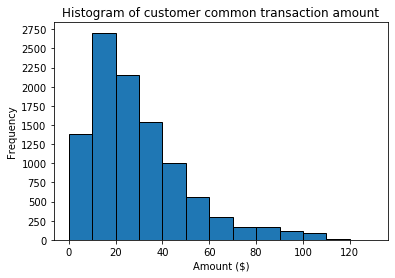

In [8]:
plt.hist(txn_amount, bins=np.arange(0, 140, 10), edgecolor = 'black')
plt.title('Histogram of customer common transaction amount')
plt.xlabel('Amount ($)')
plt.ylabel('Frequency')
plt.yticks(np.arange(0, 3000, 250))
plt.show()

In [9]:
df['month'] = df['extraction'].map(lambda x: x.month)

## Transaction frequency

### Month

In [10]:
cus_monthly_freq = df.groupby(['customer_id', 'month']).size()
cus_monthly_freq.head()

customer_id     month
CUS-1005756958  8        50
                9        14
                10        9
CUS-1117979751  8        43
                9        25
dtype: int64

In [11]:
# customer transaction behaviour average across 3 months
cus_avg_freq = cus_monthly_freq.groupby('customer_id').mean()
cus_avg_freq.head()

customer_id
CUS-1005756958    24.333333
CUS-1117979751    33.333333
CUS-1140341822    26.666667
CUS-1147642491    39.333333
CUS-1196156254    81.666667
dtype: float64

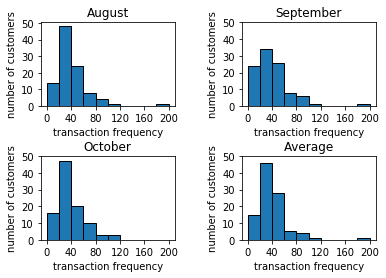

In [12]:
# Visualize customer behaviours over each month and averagely
fig = plt.figure()
axes = [fig.add_subplot(2, 2, i) for i in range(1, 5)]

for i in range(4):
    if i == 3:
        axes[i].hist(cus_avg_freq, bins=np.arange(0, 220, 20), edgecolor='k')
        axes[i].title.set_text('Average')
    else:
        axes[i].hist(cus_monthly_freq[:, i + 8], bins=np.arange(0, 220, 20), edgecolor='k')
        axes[i].title.set_text(calendar.month_name[i + 8])
    
    axes[i].set_xlabel('transaction frequency')
    axes[i].set_ylabel(f'number of customers')
    axes[i].set_xticks(np.arange(0, 240, 40))
    axes[i].set_yticks(np.arange(0, 60, 10))
    
plt.subplots_adjust(wspace=0.5, hspace=0.6)
plt.show()

### Weekday

In [13]:
df['week_day'] = df['extraction'].map(lambda x: calendar.day_name[x.weekday()])
df['date'] = df['extraction'].map(lambda x: x.date())

In [14]:
txn_weekday_avg = (df
                   .groupby(['week_day', 'date'])
                   .size()
                   .groupby('week_day')
                   .mean()
                  )
txn_weekday_avg = txn_weekday_avg.reindex(calendar.day_name)
txn_weekday_avg

week_day
Monday       104.615385
Tuesday      114.384615
Wednesday    147.357143
Thursday     150.083333
Friday       159.461538
Saturday     131.461538
Sunday       119.230769
dtype: float64

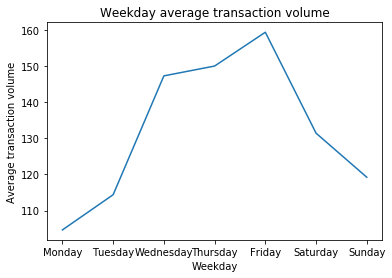

In [15]:
plt.plot(txn_weekday_avg)
plt.title('Weekday average transaction volume')
plt.xlabel('Weekday')
plt.ylabel('Average transaction volume')
plt.show()

### Hour

In [16]:
df['hour'] = df['extraction'].map(lambda x: x.hour)

In [17]:
txn_hourly_avg = (df
                 .groupby(['date', 'hour'])
                 .size()
                 .groupby('hour')
                 .mean()
                 )
txn_hourly_avg.describe()

count    24.000000
mean      5.561944
std       2.785963
min       1.421053
25%       3.011434
50%       5.818681
75%       7.068681
max      12.153846
dtype: float64

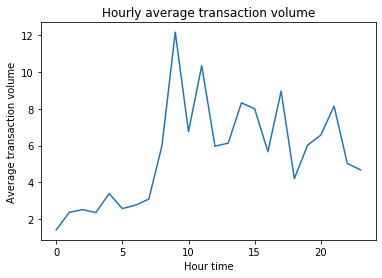

In [18]:
plt.plot(txn_hourly_avg)
plt.title('Hourly average transaction volume')
plt.xlabel('Hour time')
plt.ylabel('Average transaction volume')
plt.show()

## Transaction Purposes

### Purchase behaviour

In [19]:
# filter to get only purchase history, which is a transacrion with merchant ID
df_purchase = df[~df['merchant_id'].isna()]

In [20]:
expenditure = df_purchase['amount']
exp_summary = expenditure.describe()
exp_summary

count    7717.000000
mean       40.153732
std       149.833070
min         0.100000
25%        12.080000
50%        19.700000
75%        33.910000
max      7081.090000
Name: amount, dtype: float64

In [21]:
# exclude outliers
expenditure = expenditure[expenditure <= upper_inner_fence(exp_summary)]

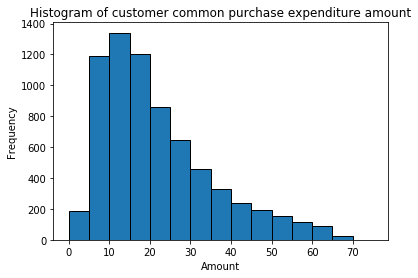

In [22]:
plt.hist(expenditure, bins=np.arange(0, 80, 5), edgecolor='k')
plt.title('Histogram of customer common purchase expenditure amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

### Salary

In [23]:
salary_3month = (df[df['txn_description'] == 'PAY/SALARY'][['customer_id', 'amount']]
                 .groupby('customer_id')
                 .sum()
                )
salary_3month['amount'].describe()

count      100.000000
mean     16765.768500
std       6741.543716
min       7155.960000
25%      11591.332500
50%      14813.485000
75%      21332.515000
max      35343.920000
Name: amount, dtype: float64

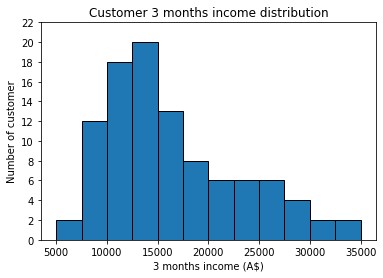

In [24]:
plt.hist(salary_3month.amount, bins=np.arange(5000, 37500, 2500), edgecolor='k')
plt.title('Customer 3 months income distribution')
plt.ylabel('Number of customer')
plt.xlabel('3 months income (A$)')
plt.yticks(np.arange(0, 24, 2))
plt.xticks(np.arange(5000, 40000, 5000))
plt.show()

# Geometry information

In [25]:
from math import sin, cos, sqrt, atan2, radians

def distance(coord1, coord2):
    '''Calculate the physical distance between 2 coordinates'''
    '''coord = [longitude, latitude]'''
    R = 6373.0 # earth radius in km
    
    lon1 = radians(coord1[0])
    lat1 = radians(coord1[1])
    lon2 = radians(coord2[0])
    lat2 = radians(coord2[1])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [26]:
# coords of customers and merchants, exclude transactions which is not a purchase behaviour
cus_coords = (df['long_lat'][~df['merchant_long_lat'].isna()]
              .str
              .split()
              .map(lambda x: [float(n) for n in x]))
mer_coords = (df['merchant_long_lat'][~df['merchant_long_lat'].isna()]
              .str
              .split()
              .map(lambda x: [float(n) for n in x]))

In [27]:
distances = np.array([distance(cus_coords[i], mer_coords[i]) for i in cus_coords.index])
pd.Series(distances).describe()

count     7717.000000
mean       562.471500
std       1367.232874
min          0.000000
25%         15.124687
50%         30.006336
75%        299.214376
max      10900.709171
dtype: float64

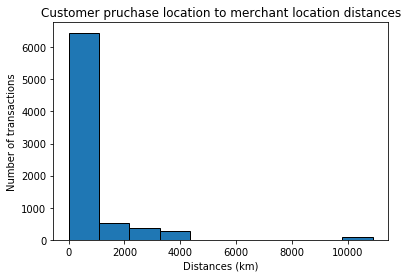

In [28]:
plt.hist(distances, edgecolor='k')
plt.title('Customer pruchase location to merchant location distances')
plt.xlabel('Distances (km)')
plt.ylabel('Number of transactions')
plt.show()

Some transactions are extremely far from merchants, check if all transactions are in australia

In [29]:
# Australian coordinates range: longitude 113 to 154, latitude -44 to -10
coords_out_of_AU = cus_coords[~cus_coords.map(lambda x: 113<x[0]<154 and -44<x[1]<10)]
df['customer_id'].loc[coords_out_of_AU.index].unique()

array(['CUS-1617121891'], dtype=object)

CUS-1617121891 is outside of Australia

In [30]:
# exclude the customer above
cus_coords_edited = cus_coords[~cus_coords.index.isin(coords_out_of_AU.index)]

In [31]:
distances_edited = np.array([distance(cus_coords_edited[i], mer_coords[i]) 
                             for i in cus_coords_edited.index])
pd.Series(distances_edited).describe()

count    7638.000000
mean      458.643990
std       911.877987
min         0.000000
25%        15.060095
50%        29.671076
75%       272.937142
max      3843.063385
dtype: float64

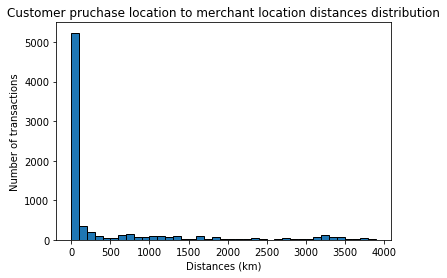

In [32]:
plt.hist(distances_edited, bins=np.arange(0, 4000, 100), edgecolor='black')
plt.title('Customer pruchase location to merchant location distances distribution')
plt.xlabel('Distances (km)')
plt.ylabel('Number of transactions')
plt.show()

We can see most of transactions are done within 100km, so we check the ditribution within 100 km

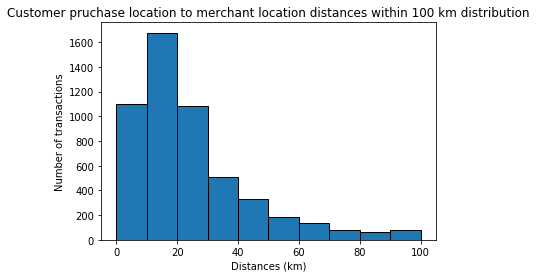

In [33]:
plt.hist(distances_edited[distances_edited < 100], bins=np.arange(0, 110, 10), edgecolor='black')
plt.title('Customer pruchase location to merchant location distances within 100 km distribution')
plt.xlabel('Distances (km)')
plt.ylabel('Number of transactions')
plt.show()

## Distribution of Merchants

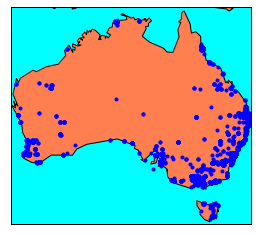

In [34]:
m = Basemap(projection='mill',llcrnrlat=-44,urcrnrlat=-10,
            llcrnrlon=113,urcrnrlon=154,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary(fill_color='aqua')

for coord in mer_coords:
    x, y = m(coord[0], coord[1])
    m.plot(x, y, marker='o', color='b', markersize=3)

plt.show()

### Specified customer traded locations

In [35]:
cus_mer_history = (pd.concat([df.loc[mer_coords.index]['customer_id'], mer_coords], axis=1)
                   .set_index('customer_id')
                  )

def purchase_locations(cus_id):
    '''returns all locations which the customer has traded with'''
    m = Basemap(projection='mill',llcrnrlat=-44,urcrnrlat=-10,
                llcrnrlon=113,urcrnrlon=154,resolution='c')
    m.drawcoastlines()
    m.fillcontinents(color='coral',lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')

    for coord in cus_mer_history.loc[cus_id].merchant_long_lat:
        x, y = m(coord[0], coord[1])
        m.plot(x, y, marker='o',color='b', markersize=3)
    
    plt.show()


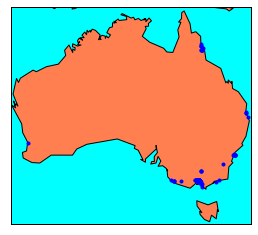

In [36]:
purchase_locations(df['customer_id'].loc[np.random.randint(len(df))])